<a href="https://colab.research.google.com/github/Yazzyhb/CoinsCounting/blob/master/CompteMonnaie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importation et chargement des **images**

In [ ]:
import kagglehub                  #pour accéder aux datasets sur Kaggle.
import matplotlib.pyplot as plt   # pour les visualisations graphiques.
import numpy as np                #pour les calculs numériques.
import pandas as pd               #pour la manipulation des données tabulaires.
from scipy import ndimage as ndi  #pour le traitement d'images.
import os                         #pour gérer les chemins de fichiers.
from PIL import Image             # pour ouvrir et manipuler des images.
# Télécharger le dataset depuis Kaggle
path = kagglehub.dataset_download("balabaskar/count-coins-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 108M/108M [00:02<00:00, 56.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1


In [ ]:
# Définir les chemins de base pour le dossier des images et le fichier CSV
base_folder = path + '/coins_images/coins_images/'  # Chemin du dossier contenant les images des pièces
csv_path = path + '/coins_count_values.csv'  # Chemin du fichier CSV contenant le nombre de pièces

def charger_images_depuis_csv(csv_path, base_folder):

    # Charger le fichier CSV à l'aide de pandas
    data = pd.read_csv(csv_path)  # Lire le fichier CSV contenant les noms des images et les comptages des pièces

    images = {}  # Dictionnaire pour stocker les images par dossier
    coin_counts = {}  # Dictionnaire pour stocker les comptages de pièces par dossier

    # Itérer sur chaque ligne du fichier CSV pour traiter les images et les comptages
    for index, row in data.iterrows():
        folder = row['folder']  # Nom du dossier contenant l'image
        image_name = row['image_name']  # Nom de l'image (fichier)
        coins_count = row['coins_count']  # Nombre de pièces correspondant à l'image

        # Construire le chemin complet vers l'image en combinant le dossier de base, le dossier et le nom de l'image
        image_path = os.path.join(base_folder, folder, image_name)

        try:
            # Tenter d'ouvrir l'image
            image = Image.open(image_path)  # Ouvrir l'image

            # Si le dossier n'est pas déjà dans le dictionnaire des images, l'initialiser avec une liste vide
            if folder not in images:
                images[folder] = []  # Initialiser la liste des images pour ce dossier
                coin_counts[folder] = []  # Initialiser la liste des comptages de pièces pour ce dossier

            # Ajouter l'image et le nombre de pièces aux listes respectives dans les dictionnaires
            images[folder].append(image)
            coin_counts[folder].append(coins_count)

        except IOError as e:
            # Gérer l'erreur si l'image ne peut pas être chargée (par exemple, fichier introuvable ou corrompu)
            print(f"Impossible de charger l'image {image_name} dans {folder}: {e}")

    # Retourner les dictionnaires des images et des comptages de pièces
    return images, coin_counts

# Charger les images et leurs comptages de pièces en appelant la fonction
images, coin_counts = charger_images_depuis_csv(csv_path, base_folder)

# Afficher le dictionnaire des images pour vérifier le résultat
print(images)


{'all_coins': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=246x205 at 0x7AC9199DCF10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=225x225 at 0x7AC91837F340>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=288x175 at 0x7AC91837F3A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=713x500 at 0x7AC91837F490>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1500x1463 at 0x7AC91837F2E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x300 at 0x7AC91837F430>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=323x156 at 0x7AC91837F220>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=286x176 at 0x7AC91837F3D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x337 at 0x7AC91837F160>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=284x177 at 0x7AC91837F310>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x7AC91837F0A0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=283x178 at 0x7A

## *Prétraitement* des images


# Conversion en Niveaux de Gris


In [ ]:
def convertir_en_niveaux_de_gris(img, scale):
    """Convertir une image en niveaux de gris et la redimensionner selon un facteur donné."""
    img = np.array(img)  # Convertir l'image en tableau NumPy
    height, width, channels = img.shape

    # Redimensionner l'image
    height, width = height // scale, width // scale
    img = np.array(Image.fromarray(img).resize((width, height), Image.Resampling.LANCZOS))

    # Initialiser un tableau vide pour l'image en niveaux de gris
    gray_array = np.zeros([height, width], dtype=np.uint8)

    # Convertir chaque pixel en niveaux de gris en faisant la moyenne des valeurs RGB
    for i in range(height):
        for j in range(width):
            gray_array[i][j] = int(sum(img[i][j]) / 3)

    # Créer une image en niveaux de gris à partir du tableau
    gray_image = Image.fromarray((gray_array * 255).astype(np.uint8))
    return gray_image

# Flou Gaussien


In [ ]:
# Fonction pour appliquer un flou gaussien à une image
def appliquer_flou_gaussien(img):
    """Appliquer un filtre de flou gaussien à une image en niveaux de gris."""
    img = np.array(img)  # Convertir l'image en tableau NumPy

    # Vérifier si l'image est en niveaux de gris ; convertir si ce n'est pas le cas
    try:
        height, width = img.shape
    except:
        img = convertir_en_niveaux_de_gris(img)

    height, width = img.shape

    # Initialiser un tableau vide pour l'image floutée
    blurred = np.zeros([height, width], dtype=np.uint8)

    # Appliquer le noyau gaussien manuellement
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            pixel = int(img[i - 1][j - 1] * 1)
            pixel += int(img[i - 1][j] * 2)
            pixel += int(img[i - 1][j + 1] * 1)
            pixel += int(img[i][j - 1] * 2)
            pixel += int(img[i][j] * 4)
            pixel += int(img[i][j + 1] * 2)
            pixel += int(img[i + 1][j - 1] * 1)
            pixel += int(img[i + 1][j] * 2)
            pixel += int(img[i + 1][j + 1] * 1)

            # Normaliser la valeur du pixel et s'assurer qu'elle est dans l'intervalle
            blurred[i][j] =verifier_debordement(int(pixel / 16))

    # Créer une image floutée à partir du tableau
    blurred_image = Image.fromarray(blurred.astype(np.uint8))
    return blurred_image

# Fonction auxiliaire pour s'assurer que les valeurs des pixels sont dans l'intervalle [0, 255]
def verifier_debordement(pixel):
    if pixel < 0:
        pixel = 0
    if pixel > 255:
        pixel = 255
    return pixel


# Ajustement du Contraste

In [ ]:
def ajuster_contrast(image,factor):
   # Définir la formule d'ajustement du contraste
    def adjust_pixel(value):
        return max(0, min(255, int(128 + factor * (value - 128))))
  # Appliquer l'ajustement à chaque pixel
    return image.point(adjust_pixel)


# Égalisation d’Histogramme

In [ ]:
def histogram_equalization(img, bins):
    img = np.array(img)
    img_flat_array = img.flatten()

    histogram = np.zeros(bins)

    # Histogramme : parcourir les pixels et additionner les occurrences des pixels
    for pixel in img_flat_array:
        histogram[pixel] += 1

    # Somme cumulative de l'histogramme
    a = iter(histogram)
    b = [next(a)]

    for i in a:
        b.append(b[-1] + i)
    cs = np.array(b)

    # Normalisation de la somme cumulative
    nj = (cs - cs.min()) * 255
    N = cs.max() - cs.min()
    cs = nj / N
    cs = cs.astype('uint8')

    # Appliquer la transformation aux pixels de l'image
    img_new = cs[img_flat_array]
    plt.hist(img_new, bins=50)

    # Reshape de l'image transformée
    img_new = np.reshape(img_new, img.shape)

    # Ajuster les bordures de l'image pour la visualisation
    img_new[0, :] = 200
    img_new[:, 0] = 200
    img_new[:, -1] = 200
    img_new[-1, :] = 200

    # Conversion en objet Image
    img_new = Image.fromarray((img_new).astype(np.uint8))

    return img_new



In [ ]:
def preprocess_image(image, scale):
    # Convertir l'image en niveaux de gris en ajustant la taille selon l'échelle spécifiée
    gray_image = convertir_en_niveaux_de_gris(image, scale)

    # Ajuster le contraste de l'image en utilisant un facteur de 1.5 pour améliorer les détails
    adjusted_image = ajuster_contrast(gray_image, 1.5)

    # Appliquer un flou gaussien à l'image pour réduire le bruit et lisser les bords
    blurred_image = appliquer_flou_gaussien(adjusted_image)

    # Effectuer une égalisation d'histogramme pour améliorer la répartition de l'éclairage
    equalized_image = histogram_equalization(blurred_image, 256)

    # Retourner l'image floutée (modifier en fonction des besoins si l'image égalisée est nécessaire)
    return blurred_image


# Segmentation des Pièces

In [ ]:
def tracer_histogramme_sur_axes(image, axes, title="Histogram"):
    """
    Trace un histogramme sur les axes fournis.

    Args:
        image: L'image à traiter, sous forme de tableau NumPy.
        axes: Les axes `matplotlib` sur lesquels tracer l'histogramme.
        title: Le titre de l'histogramme.
    """
    # Convertir l'image en tableau 1D
    image_array = np.array(image).flatten()

    # Tracer l'histogramme sur les axes donnés
    axes.hist(image_array, bins=256, range=(0, 255), color='gray', alpha=0.7, density=False)
    axes.set_title(title)
    axes.set_xlabel('Pixel Value')
    axes.set_ylabel('Frequency')
    axes.grid(axis='y', linestyle='--', alpha=0.6)  # Ajouter une grille légère


In [ ]:
def otsu_threshold(image):
    """
    Appliquer la méthode d'Otsu pour déterminer le seuil optimal pour la segmentation.
    """
    # Convertir l'image en niveaux de gris si ce n'est pas déjà fait
    # grayscale_image = to_grayscale(image)

    # Convertir l'image en un tableau numpy
    image_array = np.array(image)

    # Calculer l'histogramme et les bords des classes
    histogram, bin_edges = np.histogram(image_array, bins=256, range=(0, 256))

    # Nombre total de pixels
    total_pixels = image_array.size

    # Variables pour la méthode d'Otsu
    current_max, threshold = 0, 0
    sum_total = np.dot(np.arange(256), histogram)  # Somme de toutes les intensités de pixels
    sum_background, weight_background, weight_foreground = 0, 0, 0

    for i in range(256):
        # Mettre à jour le poids et la somme de l'arrière-plan
        weight_background += histogram[i]
        if weight_background == 0:
            continue

        # Mettre à jour le poids de l'avant-plan
        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        # Mettre à jour la somme pour l'arrière-plan
        sum_background += i * histogram[i]

        # Calculer les moyennes et la variance entre les classes
        mean_background = sum_background / weight_background
        mean_foreground = (sum_total - sum_background) / weight_foreground
        between_class_variance = (
            weight_background * weight_foreground * (mean_background - mean_foreground) ** 2
        )

        # Vérifier si cette variance est la plus grande
        if between_class_variance > current_max:
            current_max = between_class_variance
            threshold = i
    return threshold

def segmenter_pieces(image):
    """
    Segmenter une image en utilisant le seuillage d'Otsu.
    """
    # Calculer le seuil d'Otsu
    threshold = otsu_threshold(image)

    # Appliquer le seuillage
    # grayscale_image = to_grayscale(image)
    binary_image = image.point(lambda p: 255 if p > threshold else 0, mode='1')

    return binary_image



# Operations morphologiques

In [ ]:
def erosion(img, iterations=1):
    """
    Appliquer l'érosion sur une image binaire.

    Args:
        img: Image binaire sous forme de tableau NumPy ou un objet compatible.
        iterations: Nombre d'itérations d'érosion à appliquer.

    Returns:
        Image binaire après érosion.
    """
    # Convertir l'image en tableau NumPy si ce n'est pas déjà fait
    img = np.array(img)
    height, width = img.shape  # Obtenir la hauteur et la largeur de l'image

    for it in range(iterations):  # Répéter l'érosion pour le nombre d'itérations spécifié
        delete_i = []  # Liste pour stocker les indices des lignes des pixels à supprimer
        delete_j = []  # Liste pour stocker les indices des colonnes des pixels à supprimer

        # Parcourir chaque pixel à l'intérieur des bordures de l'image
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                # Vérifier si le pixel actuel est `True` et qu'il est entouré de pixels `False`
                if (
                    img[i][j] == True and (
                        img[i - 1][j] == False or  # Pixel au-dessus
                        img[i][j - 1] == False or  # Pixel à gauche
                        img[i][j + 1] == False or  # Pixel à droite
                        img[i + 1][j] == False    # Pixel en dessous
                    )
                ):
                    delete_i.append(i)  # Ajouter l'indice de la ligne
                    delete_j.append(j)  # Ajouter l'indice de la colonne

        # Mettre à jour les pixels identifiés pour suppression à `False`
        for i in range(len(delete_i)):
            img[delete_i[i]][delete_j[i]] = False

    # Retourner l'image après érosion
    return img


In [ ]:
def dilation(img, iterations=1):
    """
    Appliquer la dilatation sur une image binaire.

    Args:
        img: Image binaire sous forme de tableau NumPy ou un objet compatible.
        iterations: Nombre d'itérations de dilatation à appliquer.

    Returns:
        Image binaire après dilatation.
    """
    # Convertir l'image en tableau NumPy si ce n'est pas déjà fait
    img = np.array(img)
    height, width = img.shape  # Obtenir la hauteur et la largeur de l'image

    for it in range(iterations):  # Répéter la dilatation pour le nombre d'itérations spécifié
        add_pixel_i = []  # Liste pour stocker les indices des lignes des pixels à ajouter
        add_pixel_j = []  # Liste pour stocker les indices des colonnes des pixels à ajouter

        # Parcourir chaque pixel à l'intérieur des bordures de l'image
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                # Vérifier si le pixel actuel est `False` et qu'il est adjacent à au moins un pixel `True`
                if (
                    img[i][j] == False and (
                        img[i - 1][j] == True or  # Pixel au-dessus
                        img[i][j - 1] == True or  # Pixel à gauche
                        img[i][j + 1] == True or  # Pixel à droite
                        img[i + 1][j] == True    # Pixel en dessous
                    )
                ):
                    add_pixel_i.append(i)  # Ajouter l'indice de la ligne
                    add_pixel_j.append(j)  # Ajouter l'indice de la colonne

        # Mettre à jour les pixels identifiés pour ajout à `True`
        for i in range(len(add_pixel_i)):
            img[add_pixel_i[i]][add_pixel_j[i]] = True

    # Retourner l'image après dilatation
    return img

# Filtrage et Comptage des Pièces

In [ ]:
def filter_pieces(segmented_image):
    """
    Appliquer une combinaison d'érosion et de dilatation pour filtrer les pièces segmentées.

    Args:
        segmented_image: Image binaire segmentée (sous forme de tableau NumPy ou autre format compatible).

    Returns:
        filtered_image: Image binaire filtrée après érosion et dilatation, sous forme de PIL.Image.
    """
    # Appliquer une érosion à l'image segmentée pour supprimer les petits bruits
    erosion_image = erosion(segmented_image, 5)  # Effectuer 5 itérations d'érosion

    # Appliquer une dilatation pour restaurer la taille des objets restants
    dilation_image = dilation(erosion_image)  # Effectuer une seule itération de dilatation

    # Convertir le tableau NumPy résultant en une image PIL
    filtered_image = Image.fromarray((dilation_image))

    # Retourner l'image filtrée
    return filtered_image



Comptage des Pièces

In [ ]:

def compter_pieces(filtered_image, size_thresholds=50):
    """
    Compter le nombre de pièces et les classifier par taille (circonférence).

    Parameters:
    filtered_image: Image binaire filtrée (après détection des pièces).
    size_thresholds: Optionnel, seuil de différence de taille pour classifier les pièces.
                     Par exemple, {'small': (min_size, max_size), 'medium': (min_size, max_size), 'large': (min_size, max_size)}

    Returns:
    num_coins: Nombre total de pièces détectées.
    coin_sizes: Nombre de différences significatives de tailles détectées parmi les pièces.
    """
    # Convertir l'image PIL en un tableau NumPy
    binary_array = np.array(filtered_image)

    # Étiqueter les composants connectés (chaque pièce obtient une étiquette unique)
    labeled_array, num_coins = ndi.label(binary_array)

    # Calculer la taille de chaque composant étiqueté (aire des pièces)
    sizes = np.bincount(labeled_array.ravel())

    # Ignorer le fond (label 0) en mettant sa taille à 0
    sizes[0] = 0

    # Extraire les tailles des pièces (en excluant l'étiquette de fond)
    coin_sizes = sizes[1:]

    # Initialiser le compteur de différences significatives de tailles
    diff_count = 1

    # Comparer les tailles de toutes les paires de pièces pour détecter les différences significatives
    for i in range(len(coin_sizes)):
        for j in range(i + 1, len(coin_sizes)):
            # Calculer la différence entre les tailles des pièces
            size_diff = abs(coin_sizes[i] - coin_sizes[j])
            # Si la différence dépasse le seuil, incrémenter le compteur
            if size_diff >= size_thresholds:
                diff_count += 1

    # Appliquer une règle : si le compteur de différences est supérieur au nombre total de pièces,
    # ramener le compteur à la valeur du nombre total de pièces
    if diff_count > num_coins:
        diff_count = num_coins

    # Retourner le nombre total de pièces détectées et le nombre de différences significatives
    return num_coins, diff_count


# Visualisation des étapes du pipeline, comparaison et un comptage des pièces détaillée.

In [ ]:

import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def estimation(folder,reel_csv=None):
    """
    Cette fonction évalue les performances d'un pipeline de traitement d'images ou d'un modèle
             en comparant les prédictions aux valeurs réelles provenant d'un fichier CSV. Elle effectue
             le prétraitement, la segmentation et le filtrage des images, visualise les étapes, et
             calcule des métriques d'évaluation telles que la précision et le nombre d'erreurs.
    """
    results = []
    truth = pd.read_csv("/content/evaluation_results.csv")
    scale = 2  # Facteur d'échelle utilisé pour le traitement

    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)

        # Recherche de l'image dans le fichier CSV
        row = truth.loc[truth['image_name'] == image_name]
        if row.empty:
            print(f"Image {image_name} non trouvée dans le fichier CSV. Passage à l'image suivante.")
            continue

        # Récupérer les informations associées à l'image
        true_count = int(row['true_count'].values[0])  # Nombre réel de pièces
        predicted_count = int(row['predicted_count'].values[0])  # Nombre prédit de pièces
        num_coins = int(row['number_taille'].values[0])  # Différence ou autre métrique

        try:
            # Charger l'image
            original_image = Image.open(image_path)
            print(f"Traitement de l'image : {image_name}")


            # Prétraiter l'image
            gray_image = convertir_en_niveaux_de_gris(original_image, scale)
            adjusted_image = ajuster_contrast(gray_image, 1.5)
            blurred_image = appliquer_flou_gaussien(adjusted_image)
            equalized_image = histogram_equalization(blurred_image, 256)
            preprocessed_image = preprocess_image(original_image, scale)


            # Segmenter et filtrer l'image
            segmented_image = segmenter_pieces(preprocessed_image)
            eroded_image = erosion(segmented_image)
            dilated_image = dilation(eroded_image, 1)
            filtered_image = filter_pieces(dilated_image)


            # Afficher les images en deux lignes (Prétraitement et Segmentation)
            #fig, axes = plt.subplots(3, 5, figsize=(18, 15))
            fig = plt.figure(figsize=(18, 15))
            gs = gridspec.GridSpec(3, 5, figure=fig, wspace=0.4)
            # Première ligne pour les images de prétraitement
            axes1 = fig.add_subplot(gs[0, 0])
            axes2 = fig.add_subplot(gs[0, 1])
            axes3 = fig.add_subplot(gs[0, 2])
            axes4 = fig.add_subplot(gs[0, 3])

            # Deuxième ligne : fusion des axes pour les histogrammes
            equalized_axes = fig.add_subplot(gs[1, 0])  # Histogram Equalized
            hist_axes1 = fig.add_subplot(gs[1, 1:3])  # Fusion des colonnes 1 et 2 pour le premier histogramme
            hist_axes2 = fig.add_subplot(gs[1, 3:5])  # Fusion des colonnes 3 et 4 pour le deuxième histogramme


            # Troisième ligne pour les images de segmentation
            axes5 = fig.add_subplot(gs[2, 0])
            axes6 = fig.add_subplot(gs[2, 1])
            axes7 = fig.add_subplot(gs[2, 2])

            # Première ligne pour les images de prétraitement
            axes1.imshow(original_image, cmap='gray')
            axes1.set_title('Image originale')
            axes2.imshow(gray_image, cmap='gray')
            axes2.set_title('Image en niveau de gris')
            axes3.imshow(adjusted_image, cmap='gray')
            axes3.set_title('Image avec amelioration de contraste')
            axes4.imshow(blurred_image, cmap='gray')
            axes4.set_title('Image apres reduction de bruit')

            #Deuxième ligne pour histogram
            equalized_axes.imshow(equalized_image, cmap='gray')
            equalized_axes.set_title('Histogram Equalized')
            tracer_histogramme_sur_axes(original_image, hist_axes1, title="Histogramme de l'image originale")
            tracer_histogramme_sur_axes(preprocessed_image, hist_axes2, title="Histogramme de l'image prétraitée")


            # troisieme ligne pour les images de segmentation
            axes5.imshow(filtered_image, cmap='gray')
            axes5.set_title('Image apres segmentation')
            axes6.imshow(eroded_image, cmap='gray')
            axes6.set_title('Image apres erosion')
            axes7.imshow(dilated_image, cmap='gray')
            axes7.set_title('image apres delatation')


            """for i, ax in enumerate(axes.flatten()):
                if i == 9 or i == 7:  # Les indices 4 et 5 correspondent aux axes des histogrammes
                  ax.axis('on')  # Afficher les axes pour les histogrammes
                else:
                  ax.axis('off')  # Désactiver les axes pour les autres images"""
            for ax in [axes1, axes2, axes3, axes4, axes5, axes6, axes7, equalized_axes]:
                ax.axis('off')

            # Ajouter un titre avec les informations récupérées
            plt.suptitle(f"Image: {image_name}, Prédit: {predicted_count}, Réel: {true_count}, Différence: {num_coins}")
            plt.show()

        except Exception as e:
            print(f"Erreur lors du traitement de l'image {image_name} : {e}")

    # Calculate accuracy
    accuracy = ((total_images - total_errors) / total_images) * 100 if total_images > 0 else 0

    print(f"Evaluation Results:\n"
          f"Total Images Evaluated: {total_images}\n"
          f"Total Errors: {total_errors}\n"
          f"Accuracy: {accuracy:.2f}%")

    return {
        "results": results,
        "total_images": total_images,
        "total_errors": total_errors,
        "accuracy": accuracy
    }

# Évaluation globale avec sauvegarde des résultats corrects.

In [ ]:
import os
import shutil
import pandas as pd
from PIL import Image

def estimation(dataset_path, reel_csv, output_folder="correct_images", min_size=500):
    """
    Évaluer le système de comptage de pièces sur plusieurs images et calculer la précision.

    Args:
        dataset_path (str): Chemin vers le dossier contenant l'ensemble des images.
        reel_csv (str): Chemin vers le fichier CSV contenant les comptes réels des pièces.
        output_folder (str): Dossier où enregistrer les images correctement évaluées.
        min_size (int): Taille minimale pour filtrer les pièces.

    Returns:
        dict: Un dictionnaire avec des métriques d'évaluation (précision, nombre d'erreurs).
    """
    # Créer le dossier de sortie s'il n'existe pas
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    results = []  # Liste pour stocker les résultats des évaluations
    truth = pd.read_csv(reel_csv)  # Charger le fichier CSV des comptes réels

    total_images = 0  # Nombre total d'images traitées
    total_errors = 0  # Nombre d'images avec erreur de prédiction
    scale = 8  # Facteur d'échelle pour le prétraitement des images

    # Parcourir toutes les lignes du CSV pour traiter chaque image
    for _, row in truth.iterrows():
        folder = row['folder']  # Dossier de l'image
        image_name = row['image_name']  # Nom de l'image
        true_count = row['coins_count']  # Nombre réel de pièces

        image_path = f"{dataset_path}/{folder}/{image_name}"  # Chemin complet de l'image

        try:
            # Charger l'image
            original_image = Image.open(image_path)
            print('Traitement de l\'image :', image_name)

            # Prétraitement de l'image (conversion, ajustement, etc.)
            preprocessed_image = preprocess_image(original_image, scale)

            # Segmenter les pièces sur l'image prétraitée
            segmented_image = segmenter_pieces(preprocessed_image)
            # Filtrer les pièces pour éliminer les petites erreurs
            filtered_image = filter_pieces(segmented_image)

            # Compter le nombre de pièces détectées et les classer
            predicted_count, num_coins = compter_pieces(filtered_image)

            # Enregistrer les résultats
            total_images += 1
            is_error = predicted_count != true_count  # Vérifier si le nombre prédit correspond au nombre réel
            if is_error:
                total_errors += 1
            else:
                # Sauvegarder l'image correctement évaluée dans le dossier de sortie
                correct_image_path = os.path.join(output_folder, image_name)
                shutil.copy(image_path, correct_image_path)

            # Ajouter les résultats pour cette image à la liste des résultats
            results.append({
                "noms_images": image_name,
                "Vrai_comptes": true_count,
                "predit_comptes": predicted_count,
                "erreur_de_comptage": "Vrai" if not is_error else "Faux",
                "nombre_taille": num_coins
            })

        except Exception as e:
            # Si une erreur survient lors du traitement de l'image
            print(f"Erreur lors du traitement de {image_name}: {e}")

    # Calculer la précision du modèle
    accuracy = ((total_images - total_errors) / total_images) * 100 if total_images > 0 else 0

    # Afficher les résultats d'évaluation
    print(f"Résultats de l'Évaluation :\n"
          f"Nombre Total d'Images Évaluées : {total_images}\n"
          f"Nombre Total d'Erreurs : {total_errors}\n"
          f"Précision : {accuracy:.2f}%")

    return {
        "results": results,  # Résultats détaillés pour chaque image
        "total_images": total_images,  # Nombre total d'images évaluées
        "total_errors": total_errors,  # Nombre d'images avec erreur
        "accuracy": accuracy  # Précision du modèle
    }

Le script prend en charge deux configurations possibles pour le chemin du dataset.

Pour utiliser la première configuration :
1. Décommenter la ligne suivante : dataset_path = "/content/correct_images".
2. Commenter la ligne suivante : dataset_path = '/root/.cache/...'.
3. Commenter la ligne suivante : reel_csv = "/root/.cache/...".

Pour utiliser la deuxième configuration :
1. Décommenter la ligne suivante : dataset_path = '/root/.cache/...'.
2. Décommenter également la ligne : reel_csv = "/root/.cache/...".
3. Commenter la ligne suivante : dataset_path = "/content/correct_images"

Traitement de l'image : 01207e3d7e.jpg
Traitement de l'image : 0140acf6eb.jpg
Traitement de l'image : 025c8579f0.jpg
Traitement de l'image : 028ca794e7.jpg
Traitement de l'image : 02e080206f.jpg
Traitement de l'image : 0391d1cd81.jpg
Traitement de l'image : 03ab6f403f.jpg
Traitement de l'image : 05c7bef607.jpg
Traitement de l'image : 06592a2984.jpg
Traitement de l'image : 06dbf139bd.jpg
Traitement de l'image : 06de4d46b4.jpg
Traitement de l'image : 0712ebe773.jpg
Traitement de l'image : 078aaee7f6.jpg
Traitement de l'image : 0992f9217f.jpg
Traitement de l'image : 0bcb8457d5.jpg
Traitement de l'image : 0c0f693a3e.jpg
Traitement de l'image : 0c7067ece2.jpg
Traitement de l'image : 11178d409d.jpg
Traitement de l'image : 14080c2080.jpg
Traitement de l'image : 1573c64a86.jpg
Traitement de l'image : 1576817f96.jpg
Traitement de l'image : 16f46adcc2.jpg
Traitement de l'image : 1a1db517f0.jpg
Traitement de l'image : 1a203989bd.jpg
Traitement de l'image : 1d5fb7f409.jpg
Traitement de l'image : 1

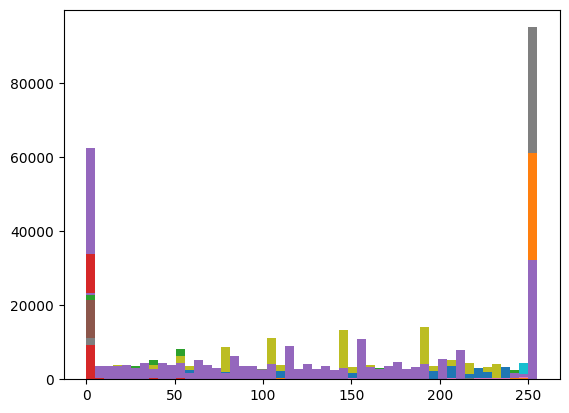

In [ ]:
if __name__ == "__main__":
    # Définir les chemins du dataset et des données de vérité terrain
    #dataset_path = "/content/correct_images"
    dataset_path = '/root/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/'
    reel_csv = "/root/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_count_values.csv"  # Chemin vers le fichier CSV contenant les données de vérité terrain

    # Définir les paramètres de filtrage et de traitement
    min_size = 500  # Taille minimale pour le filtrage des pièces

    # Appeler la fonction d'estimation
    evaluation_results = estimation(
        dataset_path,
        reel_csv=reel_csv,
        # min_size=min_size,
    )
    # Optionnellement, enregistrer les résultats détaillés dans un fichier CSV
    detailed_results = pd.DataFrame(evaluation_results["results"])
    detailed_results.to_csv("estimation_resultats.csv", index=False)
    print("Detailed results saved to estimation_resultats.csv")





# Télécharger le fichier CSV

In [ ]:
from google.colab import files
files.download("estimation_resultats.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>